In [6]:
import sys,os
sys.path.append('../')
from deep_rl import *
import matplotlib.pyplot as plt
import torch
from tqdm import trange, tqdm
import random
import numpy as np
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
!mkdir log

layout = 'open'

if layout == '3rooms' or layout == '3roomsh':
    cell_num = 101
    max_step_dqn = 1e5
    linear_schedule_dqn = 6e4
elif layout == 'maze':
    cell_num = 75
    max_step_dqn = 1.5e5
    linear_schedule_dqn = 9e4
else:
    cell_num = 104
    max_step_dqn = 7e4
    linear_schedule_dqn = 4e4


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
mkdir: log: File exists


In [36]:
import pickle

def store_agent(obj, agent_name, layout=layout):
    print('storing network')
    pickle.dump(obj, open(''+agent_name+ '.p', 'wb'))

def load_agent(agent_name):
    print('loading network')
    filename = agent_name + '.p'
    return pickle.load(open(''+filename, 'rb'))

In [13]:
print(f'{[1, 1]}')

[1, 1]


In [37]:
import numpy as np
import torch
from tqdm import trange, tqdm
import sys
sys.path.append('../..')

from deep_rl.network import *

learning_rate_dqn = 2e-3 #from 0.05 - 0.001
max_step_dqn = 1e5
linear_schedule_dqn = 6e4

def dqn_feature(config, **kwargs):
    # pre-defined config must be passed to the function
    assert config is not None

#     generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game, default_w=config.default_w)
    config.eval_env = config.task_fn()

    
    try:
        lr = config.lr
    except:
        lr = 2e-3
    
    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, lr)
    config.network_fn = lambda: DQNCNN(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(2000,))
#     config.network_fn = lambda: VanillaNet(config.action_dim, FCBody(config.state_dim, hidden_units=(16,)))
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, config.linear_schedule)
    config.discount = 0.9
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = True
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = config.max_steps
    config.async_actor = False
    agent = DQNAgent(config)

    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    # agent.step()
    # plt.figure(figsize=(10,4))
    try:
        agent.network = load_agent(f'./collector_agent/dqn/layout:{config.game}-w:{config.default_w}')
    except:
        while True:
            # print(agent.actor._task.env.envs[0].goal)
            if config.save_interval and not agent.total_steps % config.save_interval:
                agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
            if config.log_interval and not agent.total_steps % config.log_interval:
                t0 = time.time()
            if config.eval_interval and not agent.total_steps % config.eval_interval:
                agent.eval_episodes()
                pass
            if config.max_steps and agent.total_steps >= config.max_steps:
                store_agent(agent.network, f'./collector_agent/dqn/layout:{config.game}-w:{config.default_w}')
                return agent
                break
            agent.step()
            # plt.title('step: {}'.format(agent.total_steps), fontsize=20)
            # plt.imshow(agent.actor._task.env.envs[0].render(), cmap='Blues', )
            agent.switch_task()
    return agent

In [14]:
config = Config()
config.DEVICE = torch.device('cpu')
config.game = 'FourRoomsCollect'
config.linear_schedule = 6e4
config.max_steps = 1e5
config.default_w = [1, 1]

### Experiment 

In [40]:
'''
1. First we train 3 different DQN's
'''

config = Config()
config.DEVICE = torch.device('cpu')
config.game = 'FourRoomsCollect'
config.linear_schedule = 4e4
config.max_steps = 7e4
config.default_w = [1, 1]
dqn0 = dqn_feature(config)

config = Config()
config.DEVICE = torch.device('cpu')
config.game = 'FourRoomsCollect'
config.linear_schedule = 7e4
config.max_steps = 1.5e5
config.default_w = [-1, 1]
dqn1 = dqn_feature(config)

config = Config()
config.DEVICE = torch.device('cpu')
config.game = 'FourRoomsCollect'
config.linear_schedule = 7e4
config.max_steps = 1.5e5
config.default_w = [1, 0]
dqn2 = dqn_feature(config) 

loading network
loading network


2021-04-13 16:06:49,475 - root - INFO: steps 0, episodic_return_test 0.30(0.14)
2021-04-13 16:07:08,544 - root - INFO: steps 5000, episodic_return_test 0.10(0.22)
2021-04-13 16:07:21,912 - root - INFO: steps 10000, episodic_return_test 0.30(0.14)
2021-04-13 16:07:35,585 - root - INFO: steps 15000, episodic_return_test 0.80(0.37)
2021-04-13 16:07:49,537 - root - INFO: steps 20000, episodic_return_test 1.60(0.35)
2021-04-13 16:08:04,110 - root - INFO: steps 25000, episodic_return_test 0.70(0.25)
2021-04-13 16:08:18,333 - root - INFO: steps 30000, episodic_return_test 0.50(0.16)
2021-04-13 16:08:32,588 - root - INFO: steps 35000, episodic_return_test 1.60(0.35)
2021-04-13 16:08:46,895 - root - INFO: steps 40000, episodic_return_test 1.70(0.47)
2021-04-13 16:09:01,038 - root - INFO: steps 45000, episodic_return_test 2.00(0.57)
2021-04-13 16:09:15,284 - root - INFO: steps 50000, episodic_return_test 2.20(0.44)
2021-04-13 16:09:29,690 - root - INFO: steps 55000, episodic_return_test 2.20(0.5

storing network
loading network


2021-04-13 16:14:27,347 - root - INFO: steps 0, episodic_return_test 0.00(0.00)
2021-04-13 16:14:47,632 - root - INFO: steps 5000, episodic_return_test 0.00(0.00)
2021-04-13 16:15:02,584 - root - INFO: steps 10000, episodic_return_test 0.10(0.09)
2021-04-13 16:15:17,292 - root - INFO: steps 15000, episodic_return_test 0.50(0.21)
2021-04-13 16:15:32,160 - root - INFO: steps 20000, episodic_return_test 1.60(0.53)
2021-04-13 16:15:46,793 - root - INFO: steps 25000, episodic_return_test 1.10(0.22)
2021-04-13 16:16:01,956 - root - INFO: steps 30000, episodic_return_test 1.60(0.38)
2021-04-13 16:16:17,117 - root - INFO: steps 35000, episodic_return_test 0.80(0.37)
2021-04-13 16:16:32,159 - root - INFO: steps 40000, episodic_return_test 1.60(0.57)
2021-04-13 16:16:47,215 - root - INFO: steps 45000, episodic_return_test 1.70(0.49)
2021-04-13 16:17:02,840 - root - INFO: steps 50000, episodic_return_test 1.60(0.32)
2021-04-13 16:17:18,480 - root - INFO: steps 55000, episodic_return_test 2.50(0.7

storing network


In [41]:
class SRNetCNN_MultiChannel(nn.Module):
    """
    Added by Surya.
    SR fully connected body network.
    """
    def __init__(self, output_dim, body, hidden_units=(3000,), gate=F.relu, config=0):
        """
        config -> type of learning on top of state abstraction
            0 - typical SR with weights sharing
            1 - learning SR without weights sharing
        """
        super(SRNetCNN_MultiChannel, self).__init__()
        self.body = body
        self.output_dim = output_dim
        self.width = 13
        self.init_channels = int(self.body.feature_dim / np.square(self.width))

        
        # CNN layers
        self.conv1 = nn.Conv2d(self.init_channels, 128, 3, 1)
        self.conv2 = nn.Conv2d(128, 256, 3, 1)
#         self.conv3 = nn.Conv2d(64, 128, 3, 1)
        
        self.fc_size = 256 * ((self.width - (3-1)*2) // 2) ** 2

        # FC layers
        dims = (self.fc_size,) + hidden_units + (body.feature_dim * output_dim,)
#         print(self.fc_size, hidden_units, body.feature_dim, output_dim)
#         print(dims)
        self.layers = nn.ModuleList(
            [layer_init(nn.Linear(dim_in, dim_out)) for dim_in, dim_out in zip(dims[:-1], dims[1:])])
    
        print(self.layers)
        
        self.gate = gate
        self.feature_dim = body.feature_dim * output_dim
        if(config == 0):
            self.psi2q = Psi2QNet(output_dim, body.feature_dim)
        if(config == 1):
            self.psi2q = Psi2QNetFC(output_dim, body.feature_dim)
        self.to(Config.DEVICE)

    def forward(self, x):
#         print(x.shape, 'original shape')
        phi = self.body(tensor(x)) # shape: b x state_dim
        psi = phi
        
#         print(psi.shape, 'after body shape')

        # Convert to image
        psi = psi.view(phi.size(0), self.init_channels, self.width, self.width)

        # Conv layers
        psi = self.conv1(psi)
#         print(psi.shape, 'after conv1')
        psi = F.relu(psi)
        psi = self.conv2(psi)
#         print(psi.shape, 'after conv2')
        psi = F.relu(psi)
        psi = F.max_pool2d(psi, 2)
        
#         print(psi.shape, 'after pooling')
        
        psi = torch.flatten(psi, 1)

        # FC layers
        for layer in self.layers[:-1]:
            psi = self.gate(layer(psi))
        psi = self.layers[-1](psi)
        
#         print(f'debug : {psi.shape}, {psi.size(0)}, {self.output_dim}, {self.body.feature_dim}')
        
        psi = psi.view(psi.size(0), self.output_dim, self.body.feature_dim) # shape: b x action_dim x state_dim
        
#         print(f'after view shape : {psi.shape}')
        out = self.psi2q(psi)

        return phi, psi, out

In [62]:
max_step_avdsr = 5e5
linear_schedule_avdsr = 5e5
learning_rate_avdsr = 1e-3 #from 0.05 - 0.001

def avdsr_feature_A(**kwargs):
    kwargs['tag'] = 'Training avDSR based on DQN agents'
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, learning_rate_avdsr)
#     config.network_fn = lambda: SRNet(config.action_dim, SRIdentityBody(config.state_dim), \
#                                       hidden_units=(), config=0) #CHECK
    config.network_fn = lambda: SRNetCNN_MultiChannel(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(3000,), config=config.style) #CHECK
    config.replay_fn = lambda: Replay(memory_size=int(3e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1, 1, linear_schedule_avdsr) # CHECK
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.max_steps = max_step_avdsr
    config.async_actor = False
    
    agent = avDSRAgent(config, config.agents, style='DQN')
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    t0 = time.time()
    # agent.network = load_agent('avdsr-A')
    try:
        agent.network = load_agent(f'./collector_agent/avdsr/layout:{config.game}-w:{len(config.agents)}')
    except:
        while True:
            if config.log_interval and not agent.total_steps % config.log_interval:
                agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
                t0 = time.time()
            if config.max_steps and agent.total_steps >= config.max_steps:
                store_agent(agent.network, f'./collector_agent/avdsr/layout:{config.game}-w:{len(config.agents)}')
                return agent
                break
    #         import pdb; pdb.set_trace()
            agent.step()
            agent.switch_task()
      

In [70]:
store_agent(avdsr.network, f'./collector_agent/avdsr/layout:FourRoomsCollectNoTerm-w:3')

storing network


In [63]:
avdsr = avdsr_feature_A(game='FourRoomsCollectNoTerm', agents=[dqn0, dqn1, dqn2], choice=0, style=0)

no key


2021-04-14 07:16:32,715 - root - INFO: steps 0, 1572077.96 steps/s


ModuleList(
  (0): Linear(in_features=4096, out_features=3000, bias=True)
  (1): Linear(in_features=3000, out_features=2704, bias=True)
)
loading network


2021-04-14 07:17:32,020 - root - INFO: steps 1000, 16.86 steps/s
2021-04-14 07:18:30,761 - root - INFO: steps 2000, 17.03 steps/s
2021-04-14 07:19:28,945 - root - INFO: steps 3000, 17.19 steps/s
2021-04-14 07:20:26,396 - root - INFO: steps 4000, 17.41 steps/s
2021-04-14 07:21:23,752 - root - INFO: steps 5000, 17.44 steps/s
2021-04-14 07:22:20,978 - root - INFO: steps 6000, 17.48 steps/s
2021-04-14 07:23:18,761 - root - INFO: steps 7000, 17.31 steps/s
2021-04-14 07:24:15,598 - root - INFO: steps 8000, 17.60 steps/s
2021-04-14 07:25:12,794 - root - INFO: steps 9000, 17.49 steps/s
2021-04-14 07:26:10,869 - root - INFO: steps 10000, 17.22 steps/s
2021-04-14 07:27:09,448 - root - INFO: steps 11000, 17.07 steps/s
2021-04-14 07:28:06,838 - root - INFO: steps 12000, 17.43 steps/s
2021-04-14 07:29:04,593 - root - INFO: steps 13000, 17.32 steps/s
2021-04-14 07:30:01,895 - root - INFO: steps 14000, 17.45 steps/s
2021-04-14 07:30:59,469 - root - INFO: steps 15000, 17.37 steps/s
2021-04-14 07:31:56

121 0 0


Text(0.5, 1.0, 'Principle components of SFs using PCA')

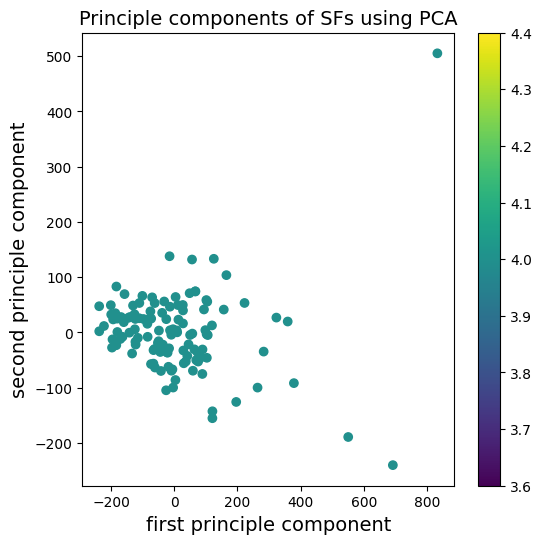

In [80]:
from deep_rl.component.fourrooms import *
from deep_rl.component.fourrooms_collect import *
g = [21, 28, 84, 91]

room1, room2, room3 = [], [], []
num = 0

agent_to_check = avdsr

if layout == '4rooms':
    num = 104
    c = np.ones(104)*4
    room1 = list(range(5)) + list(range(10,15)) + list(range(20,25)) + list(range(31,36)) +list(range(41,46))
    room2 = list(range(5,10)) + list(range(15,20)) + list(range(26,31)) + list(range(36,41)) + list(range(46,51)) + list(range(52,57))
    room3 = list(range(57,62)) + list(range(63,68)) + list(range(73,78)) + list(range(83,88)) + list(range(94,99))
    connect = [25, 51, 62, 88]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -3, -5, -7]
elif layout == '3roomsh':
    num = 101
    c = np.ones(101)*4
    room1 = list(range(0,22))
    room2 = list(range(23,67)) 
    room3 = list(range(68,101))
    connect = [22, 67]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -3]
elif layout == 'maze':
    num = 75
    c = np.ones(75)*4
    room1 = list(range(12)) + [13, 22, 26, 33, 14, 23, 27, 34, 41, 48, 52, 61, 47, 51, 60, 63] + list(range(64, 75))
    room2 = list(range(15, 22)) + [24, 28, 35, 42, 49, 25, 32, 40, 46, 50] + list(range(53, 60))
    room3 = [29, 30, 31, 37, 38, 43, 44, 45]
    connect = [12, 62, 36, 39]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -3, -5, -7]
elif layout == '3rooms':
    num = 101
    c = np.ones(101)*4
    room1 = [0,1,2,9,10,11,83,84,85,92,93,94] + list(range(19, 74, 9)) + list(range(20, 75, 9)) + list(range(21, 76, 9))
    room2 = [3,4,5,12,13,14,77,78,79,86,87,88,95,96,97] + list(range(22, 68, 9)) + list(range(23, 69, 9)) + list(range(24, 70, 9))
    room3 = [6,7,8,80,81,82,89,90,91,98,99,100] + list(range(16, 71, 9)) + list(range(17,72, 9)) + list(range(18, 73, 9))
    connect = [15, 76]
    c[room1] = 2
    c[room2] = 3
    c[room3] = 4
    c[connect] = [-1, -3]
elif layout == '3roomsm':
    num = 101
    c = np.ones(101) * 4
    room1 = [0, 1, 9, 10] + list(range(19, 74, 9)) + list(range(20, 75, 9)) + [83, 84, 92, 93]
    room2 = list(range(2, 6)) + list(range(11, 15)) + list(range(21, 67, 9)) + list(range(22, 68, 9)) + list(range(23, 69, 9)) + list(range(24, 70, 9)) + list(range(76, 80)) + list(range(85, 89)) + list(range(94, 98))
    room3 = [6,7,8] + list(range(16, 71, 9)) + list(range(17, 72, 9)) + list(range(18, 73, 9)) + [80, 81, 82, 89, 90, 91, 98, 99, 100]
    connect = [15, 75]
    c[room1] = 1
    c[room2] = 2
    c[room3] = 3
    c[connect] = [-1, -1]
elif layout == 'open':
    num = 121
    c = np.ones(121) * 4
    room1 = list(range(121))
    

print(len(room1), len(room2), len(room3))

env = ClctFourRooms(layout='open')
psi_all = np.zeros((num,169*4*4))
for i in range(num):
    state = env.reset()
    env.agent_pos = i
    _, out, _ = agent_to_check.network(tensor(state).unsqueeze(0))
    psi = out.detach().cpu().numpy()
    psi_all[i,:] = psi.flatten()

psi_all.shape

from sklearn.decomposition import PCA
plt.figure(figsize=(6,6),dpi=100)
pca = PCA(n_components=2)
k = pca.fit_transform(psi_all)
plt.scatter(k[:,0],k[:,1], c=c)
plt.xlabel('first principle component', fontsize=14)
plt.ylabel('second principle component', fontsize=14)
plt.colorbar()
plt.title('Principle components of SFs using PCA', fontsize=14)

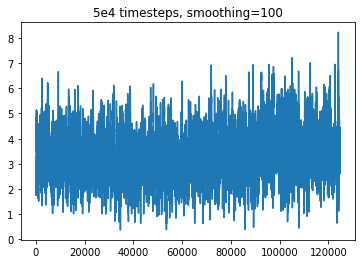

(Text(0.5, 1.0, '5e4 timesteps, smoothing=100'), None)

In [73]:
loss_lr_em3 = avdsr.loss_vec
kernel = 100
plt.plot(convolve(avdsr.loss_vec[20:], kernel))
plt.title('5e4 timesteps, smoothing=' + str(kernel)), plt.show()

In [72]:
def dsr_feature_init(ref,**kwargs):
    generate_tag(kwargs)
    kwargs.setdefault('log_level', 0)
    config = Config()
    config.async_actor = False
    config.merge(kwargs)

    config.task_fn = lambda: Task(config.game)
    config.eval_env = config.task_fn()
    config.c = 1

    config.optimizer_fn = lambda params: torch.optim.RMSprop(params, 0.002)
    config.network_fn = lambda: SRNetCNN_MultiChannel(config.action_dim, SRIdentityBody(config.state_dim), \
                                      hidden_units=(3000,), config=config.style) #CHECK
    config.replay_fn = lambda: AsyncReplay(memory_size=int(1e5), batch_size=10)

    config.random_action_prob = LinearSchedule(1.0, 0.1, linear_schedule_dqn)
    config.discount = 0.99
    config.target_network_update_freq = 200
    config.exploration_steps = 0
    # config.double_q = Truez
    config.double_q = False
    config.sgd_update_frequency = 4
    config.gradient_clip = 5
    config.eval_interval = int(5e3)
    config.max_steps = max_step_dqn
    config.async_actor = False
    
    agent = DSRAgent(config)
    #run_steps function below
    config = agent.config
    agent_name = agent.__class__.__name__
    if(ref is not None):
        print(agent.network.load_state_dict(ref.network.state_dict(), strict=False))
    t0 = time.time()
    while True:
        if config.save_interval and not agent.total_steps % config.save_interval:
            agent.save('data/%s-%s-%d' % (agent_name, config.tag, agent.total_steps))
        if config.log_interval and not agent.total_steps % config.log_interval:
#             agent.logger.info('steps %d, %.2f steps/s' % (agent.total_steps, config.log_interval / (time.time() - t0)))
            t0 = time.time()
        if config.eval_interval and not agent.total_steps % config.eval_interval:
            agent.eval_episodes()
        if config.max_steps and agent.total_steps >= config.max_steps:
            return agent
            break
#         import pdb; pdb.set_trace()
        agent.step()
        agent.switch_task()
        
    return agent


dsr = dsr_feature_init(ref=avdsr, game='FourRoomsCollect', freeze=2, style=0)

ModuleList(
  (0): Linear(in_features=4096, out_features=3000, bias=True)
  (1): Linear(in_features=3000, out_features=2704, bias=True)
)
ModuleList(
  (0): Linear(in_features=4096, out_features=3000, bias=True)
  (1): Linear(in_features=3000, out_features=2704, bias=True)
)
<All keys matched successfully>


2021-04-14 18:25:05,201 - root - INFO: steps 0, episodic_return_test 0.40(0.15)
2021-04-14 18:28:28,971 - root - INFO: steps 5000, episodic_return_test 0.60(0.21)
2021-04-14 18:31:47,993 - root - INFO: steps 10000, episodic_return_test 0.40(0.21)
2021-04-14 18:35:04,092 - root - INFO: steps 15000, episodic_return_test 0.50(0.16)
2021-04-14 18:38:22,321 - root - INFO: steps 20000, episodic_return_test 0.40(0.21)
2021-04-14 18:41:45,168 - root - INFO: steps 25000, episodic_return_test 0.50(0.21)
2021-04-14 18:45:07,660 - root - INFO: steps 30000, episodic_return_test 0.10(0.09)
2021-04-14 18:48:29,396 - root - INFO: steps 35000, episodic_return_test 0.10(0.09)
2021-04-14 18:51:52,412 - root - INFO: steps 40000, episodic_return_test 0.10(0.09)
2021-04-14 18:55:18,324 - root - INFO: steps 45000, episodic_return_test 0.60(0.21)
2021-04-14 18:58:46,992 - root - INFO: steps 50000, episodic_return_test 0.00(0.00)
2021-04-14 19:02:16,828 - root - INFO: steps 55000, episodic_return_test 0.50(0.2